Testing the difference between differend algorithms

In [1]:
import sys
sys.path.append('../')

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import math
import yaml
from utils.plot import *
from utils.fitness_controller import FitnessController

Visualization settings

In [3]:
BASE_PATH = '../results/lenet_tanh_compress_50/'
SAVE_FILES = {
    'RND': 'lenet_RND_save.csv',
    'PSO': 'lenet_PSO_save.csv',
    'GA': 'lenet_GA_save.csv',
}

SAVE_PLOTS = False
SAVE_PLOTS_LOC = '../results/plots/'
SAVE_PLOT_ID = 1


Data loaded from experiment settings

In [4]:
cf = None

with open(os.path.join(BASE_PATH, 'experiment_setting.yaml'), 'r') as config:
    cf = yaml.safe_load(config)

OPTIM_TARGET = cf['target']['point']
OPTIM_TARGET_LOCK = cf['target']['lock']
OPTIM_TARGET_UPDATE_OFFSET = cf['target']['update offset']
OPTIM_TARGET_LOW_LIMIT = cf['target']['update limit']

def fit_from_vals(data, targ_vals):
    return 1 / math.sqrt(pow(1 - (data['accuracy'] - 0.9)/0.1, 2) + pow(1 - (data['compression']/targ_vals[1]), 2))

Loaded data structures

In [5]:
data = {
    'run': [],
    'RND': [],
    'PSO': [],
    'GA': [],
}

data_complete = {
    'run': [],
    'accuracy': [],
    'accuracy_loss': [],
    'compression': [],
    'fitness':[],
    'type': [],
}

# some data have old computed fitness, to compare them with recalculated values uncomment follofwing old_dit codes
#old_fit = {
#    'run': [],
#    'RND': [],
#    'PSO': [],
#    'GA': [],
#}

# all dirs with the experiment data
exp_dirs = [name for name in os.listdir(BASE_PATH) if os.path.isdir(os.path.join(BASE_PATH, name))]

Getting correct fitness controler target value by observing all the data

In [6]:
fit_cont = FitnessController(OPTIM_TARGET, None, fit_from_vals, target_max_offset=OPTIM_TARGET_UPDATE_OFFSET, 
    target_limit=OPTIM_TARGET_LOW_LIMIT, lock=OPTIM_TARGET_LOCK)

for dir in exp_dirs:
    for key in SAVE_FILES.keys():

        save_df = pd.read_csv(os.path.join(BASE_PATH, dir, SAVE_FILES[key]))
        
        fit_cont.fit_from_df(save_df, verbose=True)

print(fit_cont.targ)

[ 1. 18.]


Get data for boxplots

In [7]:
for dir in exp_dirs:

    data['run'].append(dir)
    #old_fit['run'].append(dir)

    for key in SAVE_FILES.keys():
        
        # loading the data
        save_df = pd.read_csv(os.path.join(BASE_PATH, dir, SAVE_FILES[key]))

        # dropping fitness column if found
        if 'fitness' in save_df.columns:
            #old_fit[key].append(save_df['fitness'].max())
            save_df = save_df.drop('fitness', axis=1)

        # get correct fitness row by current fitness controller
        fit_cont.fit_from_df(save_df, verbose=True)

        # saving best found row
        data_row = (save_df[save_df['fitness'] == save_df['fitness'].max()]).iloc[0]
        
        data_complete['run'].append(dir)
        data_complete['accuracy'].append(data_row['accuracy'])
        data_complete['accuracy_loss'].append(data_row['accuracy_loss'])
        data_complete['compression'].append(data_row['compression'])
        data_complete['fitness'].append(data_row['fitness'])
        data_complete['type'].append(key)

        data[key].append(data_row['fitness'])

data = pd.DataFrame(data)
data_complete = pd.DataFrame(data_complete)

Optimization comparsion boxplot graph

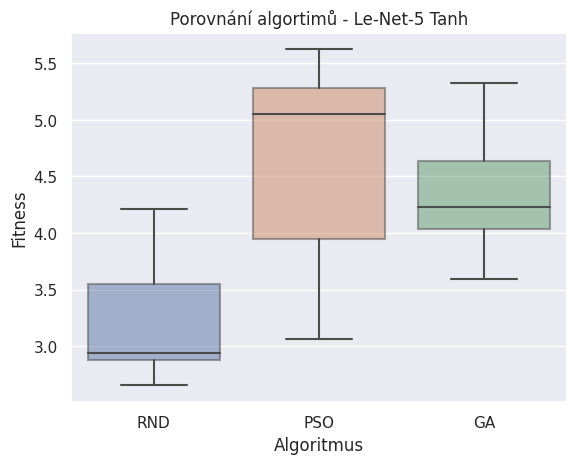

In [8]:
sns.set(style="darkgrid")
graph = sns.boxplot(data=data, boxprops=dict(alpha=0.5)) #  medianprops={"color": "coral"}
graph.set(xlabel = 'Algoritmus', ylabel='Fitness', title='Porovnání algortimů - Le-Net-5 Tanh')

if SAVE_PLOTS:
    graph.get_figure().savefig(os.path.join(SAVE_PLOTS_LOC, f'box{SAVE_PLOT_ID}.pdf'))

Optimization progress graph

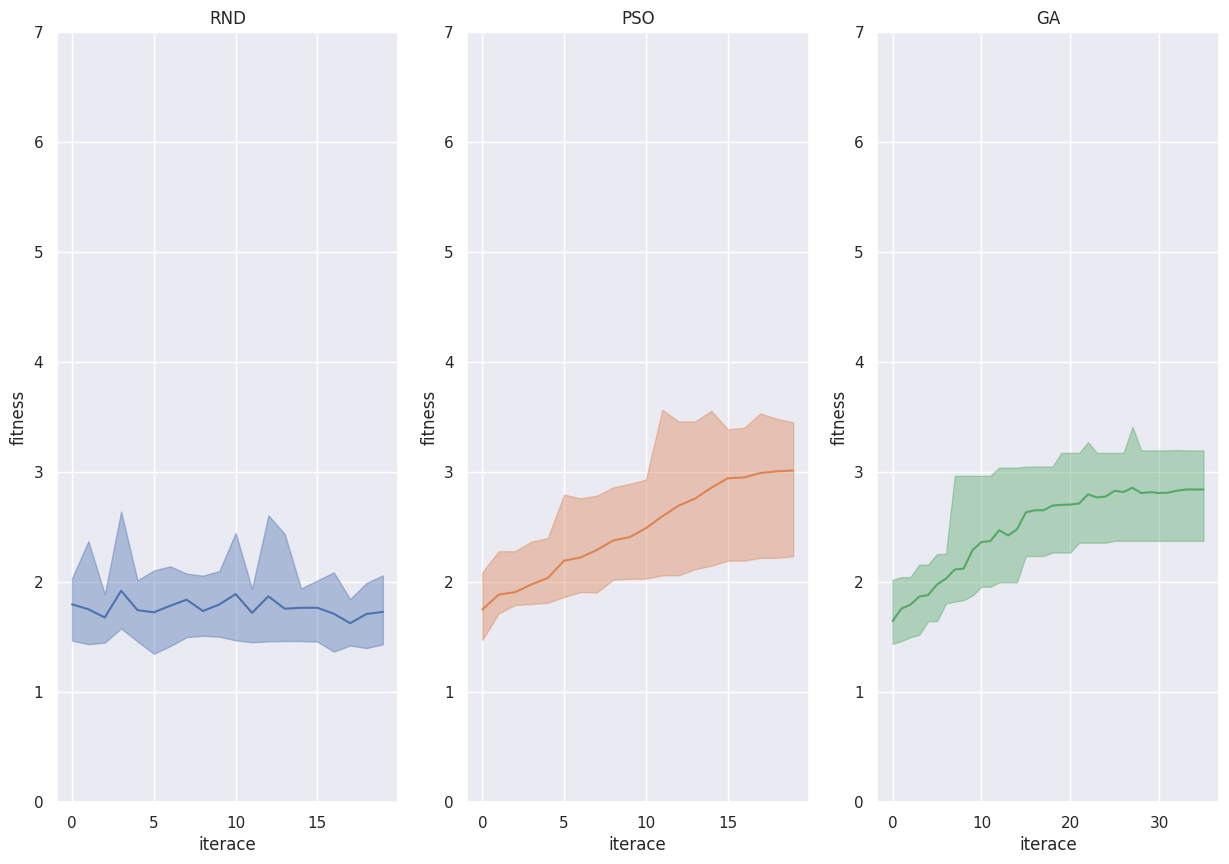

In [18]:
files = {
    'RND': [],
    'PSO': [],
    'GA': [],
}

for key in files.keys():
    for i in range(1, 12):
        files[key].append(f'{BASE_PATH}run{i}/lenet_{key}_save.csv')

plot_optimalization_progress(files, fit_cont)

if SAVE_PLOTS:
    plt.savefig(os.path.join(SAVE_PLOTS_LOC, f'line{SAVE_PLOT_ID}.pdf'))

Comparsion of optimization techiques

<AxesSubplot:xlabel='compression', ylabel='accuracy_loss'>

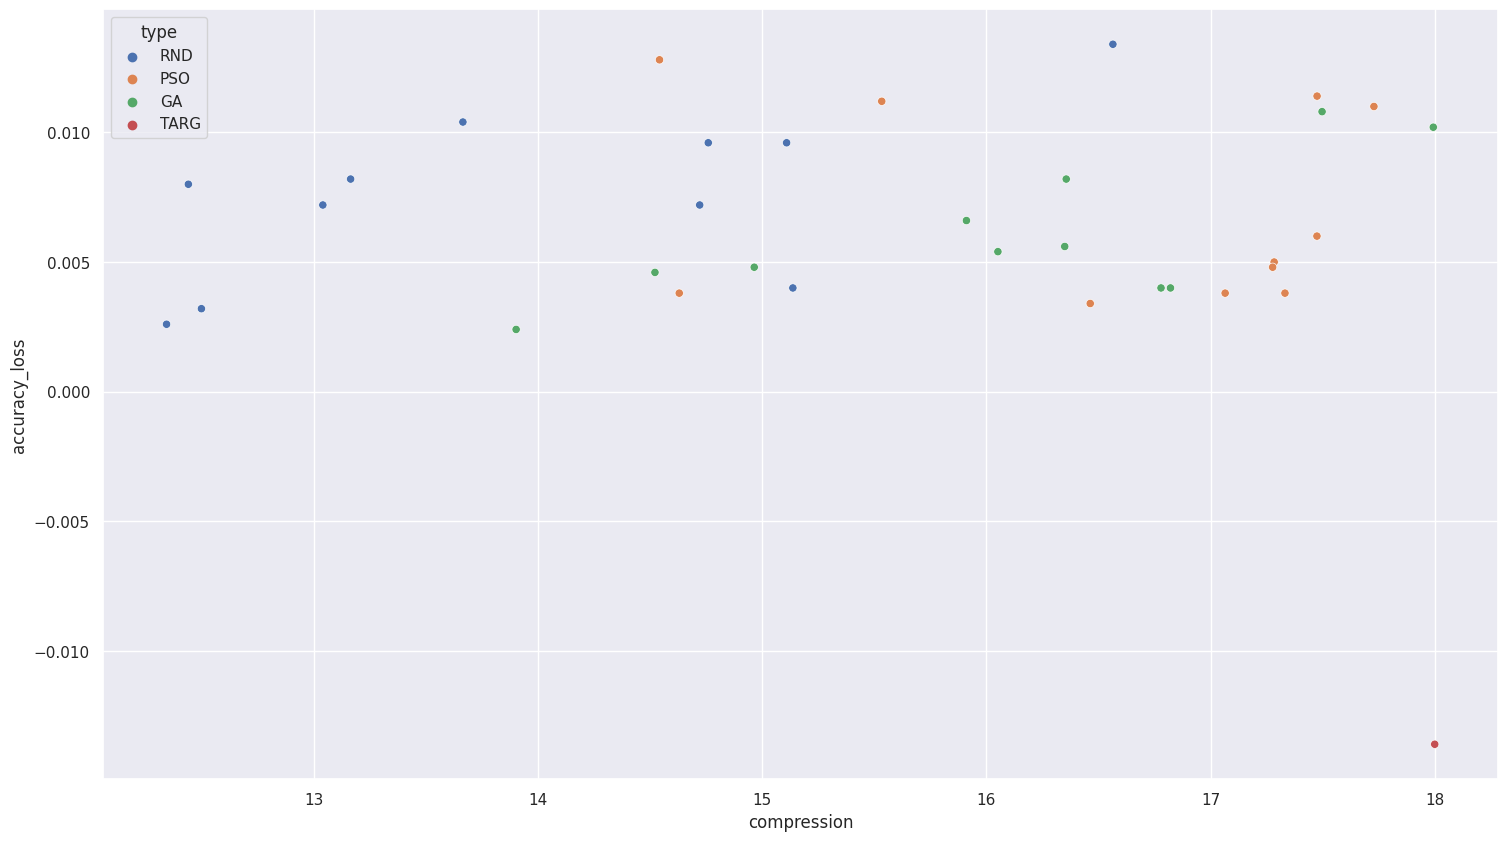

In [10]:
before_loss = data_complete.loc[0]['accuracy'] + data_complete.loc[0]['accuracy_loss'] 
data_complete.loc[len(data_complete.index)] = ['run0', fit_cont.targ[0], before_loss - fit_cont.targ[0], fit_cont.targ[1], 0, 'TARG']

sns.set(rc={'figure.figsize': (18, 10)})
sns.scatterplot(data=data_complete, x='compression', y='accuracy_loss', hue='type')

Showing performance graphs

In [11]:
plt_data = pd.read_csv('../results/lenet_tanh_compress_50/run3/lenet_PSO_save.csv')
plt_data

,time,fitness,position,representation,velocity,accuracy,accuracy_loss,compression,share_t,train_t,acc_t
0,0,1.732364,"[3.731806905825205, 6.372498903461125, 12.4996...","[38, 30, 23, 5, 4]","[0.9732354174824229, -4, -1.9122947083896837, ...",0.9856,0.0008,7.938069,0.919930,0.0,3.160629
1,0,1.522746,"[3.5570002984310527, 6.358679509005547, 10.035...","[40, 13, 8, 12, 44]","[0.7692454211831372, 3.533102979714535, -3.112...",0.9864,0.0000,6.435505,0.628740,0.0,3.262684
2,0,1.321078,"[3.6876980746380736, 5.360708849591451, 9.9729...","[50, 42, 20, 26, 50]","[-2.2845815165328887, 4, -4, -0.24732001394392...",0.9860,0.0004,4.609828,1.096465,0.0,3.338651
3,0,1.391657,"[5.894372895156042, 1.3441805890013976, 11.700...","[41, 12, 44, 25, 19]","[-1.1765617225730638, -2.890712494724972, -4, ...",0.9854,0.0010,5.335575,1.497669,0.0,3.184463
4,0,1.623546,"[5.929755008576516, 7.6312570537774365, 15.379...","[37, 39, 32, 10, 4]","[4, 1.489451176632232, -4, -0.3038603576271572...",0.9860,0.0004,7.203347,1.159793,0.0,3.158234
...,...,...,...,...,...,...,...,...,...,...,...
395,19,5.351959,"[3.212066484962281, 3.8919646357736633, 13.299...","[6, 6, 15, 2, 2]","[0.8328471930363693, -1.0860418519206152, 1.97...",0.9816,0.0048,17.415075,0.567674,0.0,3.237017
396,19,4.999239,"[6.654434824252492, 4.601429506367396, 12.9742...","[9, 7, 14, 2, 2]","[0.45153794482478427, 0.20026057475867431, -3....",0.9808,0.0056,16.990044,0.562792,0.0,3.214768
397,19,4.703938,"[7.057352422378369, 12.473751180700992, 16.136...","[10, 15, 18, 2, 2]","[0.6701260654117855, 3.7891581479232332, 1.905...",0.9816,0.0048,16.083393,0.715158,0.0,3.294877
398,19,4.351249,"[6.042212077068538, 2.9861341264431283, 15.901...","[9, 5, 17, 2, 2]","[2.0189814300203883, -3.5817907734517367, 3.19...",0.9782,0.0082,16.690470,0.664030,0.0,3.215213


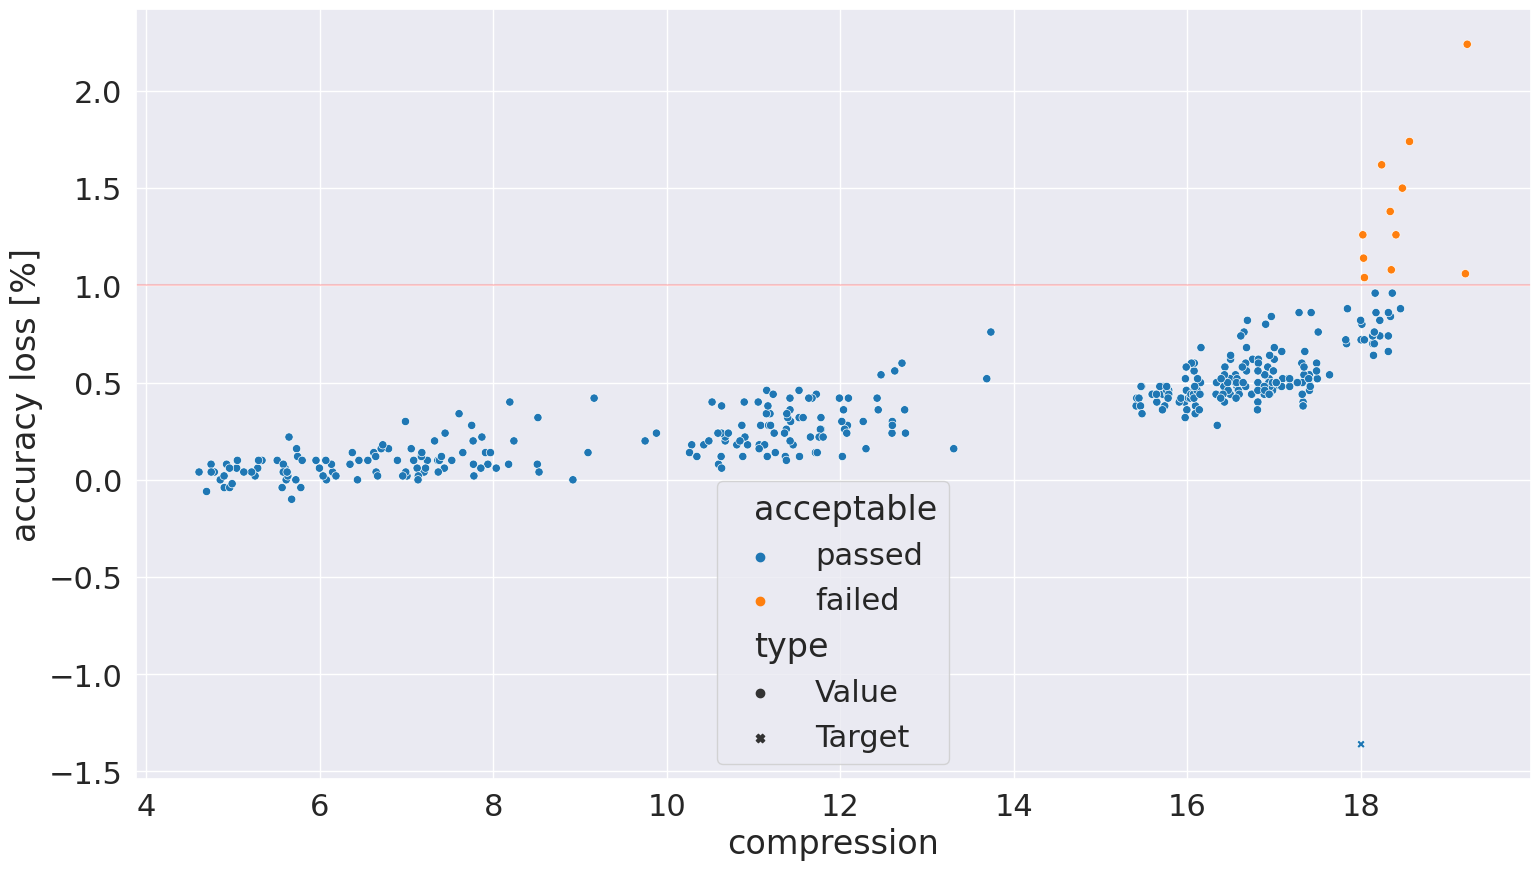

In [12]:
#plt_data = pd.read_csv('../results/lenet_tanh_compress_50/run10/lenet_PSO_save.csv')
#plt_data = pd.read_csv('../results/lenet_relu_compress_50/run8/lenet_PSO_save.csv')
#plt_data = pd.read_csv('../results/lenet_relu_compress_50/run9/lenet_GA_save.csv')

plot_alcr(plt_data, True, [1.0, 18.0])
#plt.title('GA algoritmus - LeNet-5 ReLu')
#plt.xlabel('Komprese')
#plt.ylabel('Ztráta přesnosti [%]')

if SAVE_PLOTS:
    plt.savefig(os.path.join(SAVE_PLOTS_LOC, f'scatter{SAVE_PLOT_ID}.pdf'))

Compare two experiments (meant for dynamic and static target)

In [7]:
FOLDERS_EXP = [
    {'path': '../results/lenet_tanh_compress_50/', 'type': 'static'}, 
    {'path': '../results/lenet_tanh_compress_50_dynamic_full/', 'type': 'dynamic full'},
    {'path': '../results/lenet_tanh_compress_50_dynamic_normal/', 'type': 'dynamic normal'}
    ]

SAVE_FILES = {
    #'PSO': 'lenet_PSO_save.csv',
    'GA': 'lenet_GA_save.csv',
}

def fit_from_vals(data, targ_vals):
    return 1 / math.sqrt(pow(1 - (data['accuracy'] - 0.9)/0.1, 2) + pow(1 - (data['compression']/targ_vals[1]), 2))

In [8]:
fit_conts = []

data_complete = {
    'run': [],
    'accuracy': [],
    'accuracy_loss': [],
    'compression': [],
    'fitness':[],
    'type': [],
    'tar_type': [],
}

for experiment in FOLDERS_EXP:

    exp_dirs = [name for name in os.listdir(experiment['path']) if os.path.isdir(os.path.join(experiment['path'], name))]

    # load config
    cf = None

    with open(os.path.join(experiment['path'], 'experiment_setting.yaml'), 'r') as config:
        cf = yaml.safe_load(config)
    
    print(experiment['path'], cf['target']['point'], cf['target']['lock'])

    # update curresponding fitness controller target
    fit_conts.append(FitnessController(cf['target']['point'], None, fit_from_vals, target_max_offset=cf['target']['update offset'], 
        target_limit=cf['target']['update limit'], lock=cf['target']['lock']))

    for dir in exp_dirs:
        for key in SAVE_FILES.keys():

            save_df = pd.read_csv(os.path.join(experiment['path'], dir, SAVE_FILES[key]))
            
            fit_conts[-1].fit_from_df(save_df, verbose=True)

    print(fit_conts[-1].targ)

    for dir in exp_dirs:

        for key in SAVE_FILES.keys():
            
            # loading the data
            save_df = pd.read_csv(os.path.join(experiment['path'], dir, SAVE_FILES[key]))

            save_df = save_df[save_df['accuracy_loss'] < 0.01]

            # dropping fitness column if found
            if 'fitness' in save_df.columns:
                #old_fit[key].append(save_df['fitness'].max())
                save_df = save_df.drop('fitness', axis=1)

            # get correct fitness row by current fitness controller
            fit_conts[-1].fit_from_df(save_df, verbose=True)

            # saving best found row
            data_row = (save_df[save_df['fitness'] == save_df['fitness'].max()]).iloc[0]
            
            data_complete['run'].append(dir)
            data_complete['accuracy'].append(data_row['accuracy'])
            data_complete['accuracy_loss'].append(data_row['accuracy_loss'])
            data_complete['compression'].append(data_row['compression'])
            data_complete['fitness'].append(data_row['fitness'])
            data_complete['type'].append(key)
            data_complete['tar_type'].append(experiment['type'])

data_complete = pd.DataFrame(data_complete)


../results/lenet_tanh_compress_50/ [1.0, 18.0] True
[ 1. 18.]
../results/lenet_tanh_compress_50_dynamic_full/ [1.0, 1.0] False
Fitness target update to [ 1.       22.761524]
[ 1.       22.761524]
../results/lenet_tanh_compress_50_dynamic_normal/ [1.0, 18.0] False
Fitness target update to [ 1.       21.690275]
Fitness target update to [ 1.       22.411316]
[ 1.       22.411316]


In [9]:
data_complete.tail()

,run,accuracy,accuracy_loss,compression,fitness,type,tar_type
28,run9,0.9770,0.0094,19.220550,3.696862,GA,dynamic normal
29,run11,0.9780,0.0084,13.683573,2.235736,GA,dynamic normal
30,run1,0.9774,0.0090,16.343437,2.835446,GA,dynamic normal
31,run5,0.9786,0.0078,19.015036,3.813537,GA,dynamic normal
32,run6,0.9778,0.0086,19.415773,3.859033,GA,dynamic normal


In [10]:
before_loss = data_complete.loc[0]['accuracy'] + data_complete.loc[0]['accuracy_loss']

for i, fit_cont in enumerate(fit_conts):
    data_complete.loc[len(data_complete.index)] = ['run0', fit_cont.targ[0], before_loss - fit_cont.targ[0], fit_cont.targ[1], 0, 'TARG', FOLDERS_EXP[i]['type']]

<AxesSubplot:xlabel='compression', ylabel='accuracy_loss'>

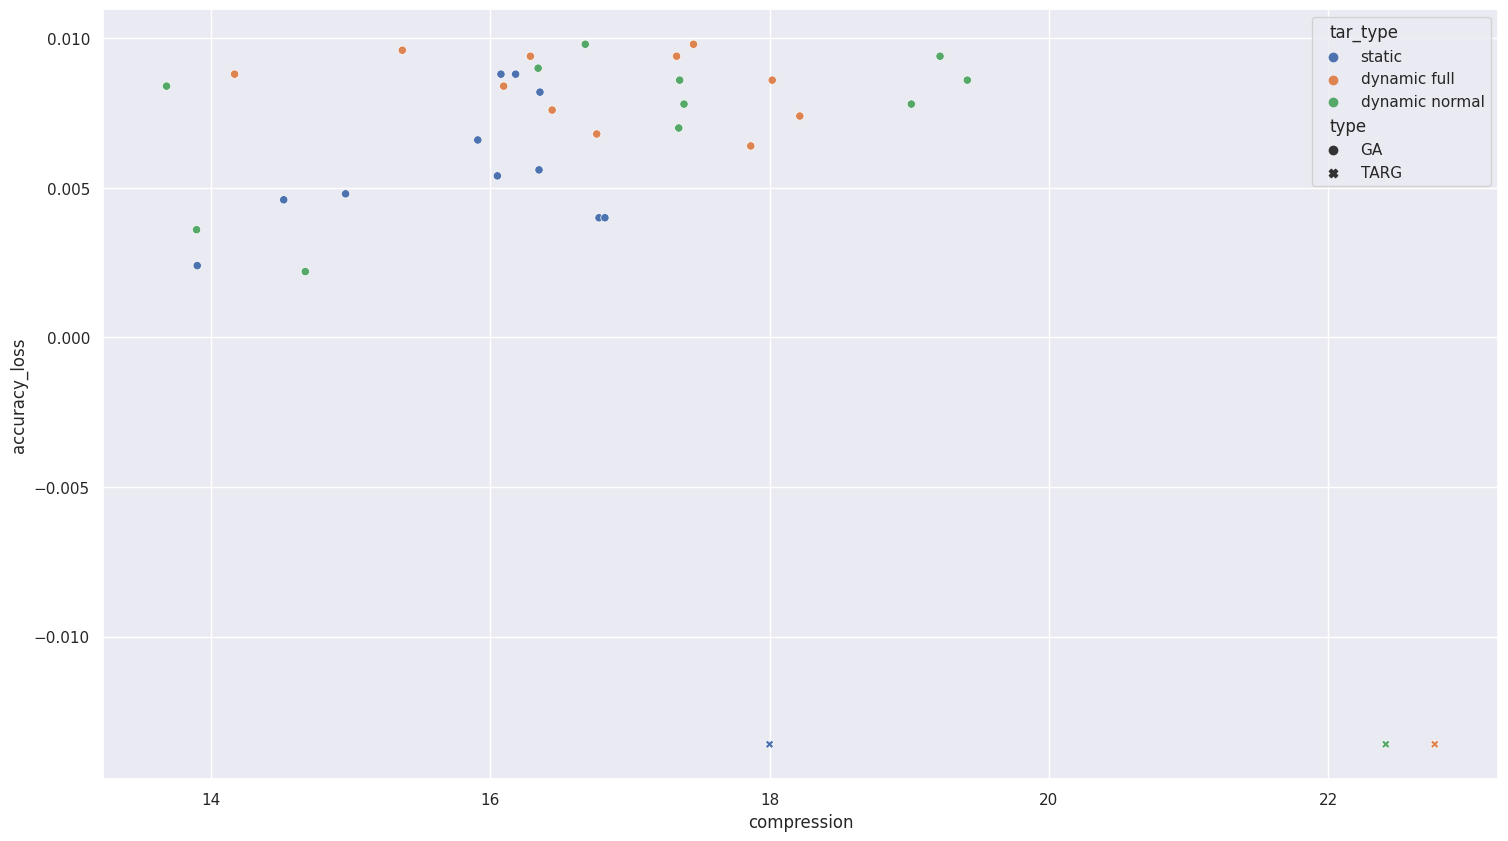

In [11]:
sns.set(rc={'figure.figsize': (18, 10)})
sns.scatterplot(data=data_complete, x='compression', y='accuracy_loss', style='type', hue='tar_type')